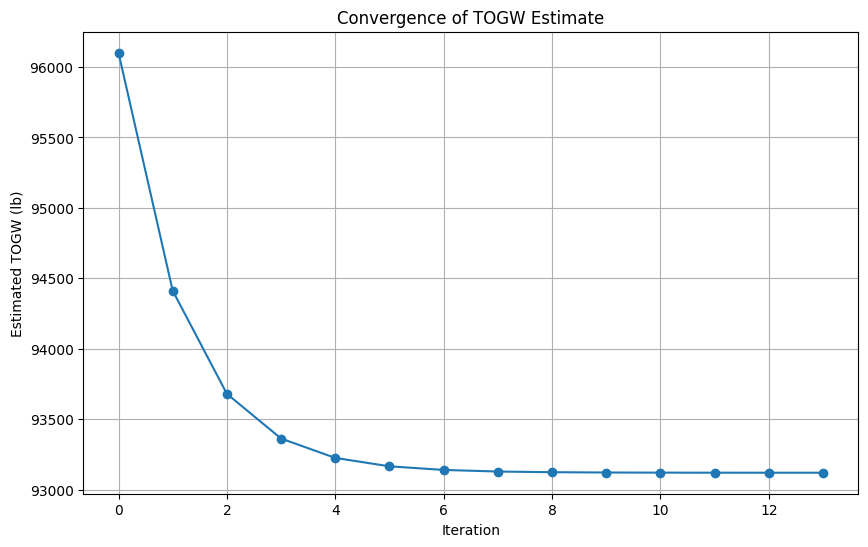

Final estimated TOGW: 93119.37300330857 lb


TypeError: outer_loop_thrust_for_one_constraint() got an unexpected keyword argument 'Wcrew'. Did you mean 'W_crew'?

In [11]:
import numpy as np
import matplotlib.pyplot as plt

AR = 2.5
s = 130
s_ref = 2049 
rho = 0.0023765
VStall = 135
Clmax = 1.5


Stall_constraint = 0.5 * rho * (VStall**2) * Clmax

#innerloop:weight convergence
def calculate_engine_weight(T_0):
    W_eng_dry = 0.521 ** T_0**0.9
    W_eng_oil = 0.082 * T_0 ** 0.65
    W_eng_rev = 0.0034 * T_0
    W_eng_control = 0.26 * T_0**0.5
    W_eng_control= 0.26 * T_0**0.5
    W_eng_start = 9.33 * (W_eng_dry/1000)**1.078
    W_eng = W_eng_dry + W_eng_oil + W_eng_rev + W_eng_control + W_eng_start
    return W_eng

def calculate_empty_weight(S_wing, S_ht, S_vt, S_wet_fuselage, TOGW, T_0 , num_engines):
    W_wing = S_wing * 9
    W_ht = S_ht * 4
    W_vt = S_vt * 5.3
    W_fuselage = S_wet_fuselage * 4.8
    W_landing_gear = 0.033 * TOGW
    Engine_weight = calculate_engine_weight(T_0)
    W_engines = Engine_weight * num_engines * 1.3
    W_all_else = 0.17 * TOGW
    W_empty = W_wing + W_ht + W_vt + W_fuselage + W_landing_gear + W_engines + W_all_else
    return W_empty

def calculate_weight_fraction(L_D_max,R,E,c,V):
    L_D = 0.94 * L_D_max
    W3_W2 = np.exp((-R*c)/(V*L_D))
    W4_W3 = np.exp((-E*c) / (L_D))
    warmup   = 0.99  # Warm up fuel fraction (Wn/W0)
    taxi     = 0.99  # Taxi fuel fraction (Wn/W0)
    takeoff  = 0.99  # Takeoff fuel fraction (Wn/W0)
    climb    = 0.96
    combat   = 0.94
    descent  = 0.99  # Descent fuel fraction (Wn/W0)
    landing  = 0.995 # Landing fuel fraction (Wn/W0)
    goaround = 0.99
    W5_W0 = W3_W2 * W4_W3 * warmup * taxi * takeoff * climb * combat * descent * landing * goaround
    Wf_W0 = (1 - W5_W0) * 1.06
    return Wf_W0

def inner_loop_weight(
    TOGW_guess,
    S_wing, S_ht, S_vt, S_wet_fuselage,
    num_engines, w_crew, w_payload, T_0,
    err=1e-6,
    max_iter=200
):
    W0_history = []
    delta = np.inf
    it = 0

    while delta > err and it < max_iter:
        # 1) fuel fraction (could be constant or updated)
        Wf_W0 = calculate_weight_fraction(L_D_max, R, E, c, V)
        W_fuel = Wf_W0 * TOGW_guess

        # 2) empty weight based on current TOGW guess + geometry + thrust
        W_empty = calculate_empty_weight(
            S_wing, S_ht, S_vt, S_wet_fuselage,
            TOGW_guess, T_0, num_engines
        )

        # 3) new gross weight
        W0_new = W_empty + w_crew + w_payload + W_fuel
        W0_history.append(W0_new)

        # 4) convergence check
        delta = abs(W0_new - TOGW_guess) / max(abs(W0_new), 1e-9)

        # 5) update
        TOGW_guess = W0_new
        it += 1

    converged = (delta <= err)
    return TOGW_guess, converged, it, np.array(W0_history)
    
# Fixed parameters for weight estimation
L_D_max = 14
R = 2000            # nmi, from payload-range chart with 35000 kg payload, from the spec data by boeing, found the Range ~ 7725 nmi
E = 0.333       # min --> hr
c = 0.52            # lb/(lbf hr)
V = 550 * 1.94384   # m/s --> knots

S_ht = 40
S_vt = 30
S_wet_fuselage = 500 
num_engines = 2  # Example number of engines

# The value we can adjust by the constraint curve. For example, if we want to be on the takeoff constraint curve, we can find the corresponding W/S and then calculate the TOGW based on that W/S and the wing area.
S_wing = 4605
T_0 = 93700  # Example value for thrust per engine
Wcrew = 400          # Crew weight in lbs
Wpayload = 6802
TOGW_guess = 100000  # Initial guess for Takeoff Gross Weight in pounds
final_TOGW, converged, iterations, W0_history = inner_loop_weight(
    TOGW_guess,
    S_wing, S_ht, S_vt, S_wet_fuselage,
    num_engines, Wcrew, Wpayload, T_0
)

# ploy the convergence history
plt.figure(figsize=(10,6))
plt.plot(W0_history, marker='o')
plt.title('Convergence of TOGW Estimate')
plt.xlabel('Iteration')
plt.ylabel('Estimated TOGW (lb)')
plt.grid()
plt.show()
print("Final estimated TOGW:", final_TOGW, "lb")

def outer_loop_thrust_for_one_constraint(
    S_wing_grid,
    TOGW_guess_init,
    T_total_guess_init,      # total thrust guess (all engines), lbf
    num_engines,
    S_ht, S_vt, S_wet_fuselage,
    W_crew, W_payload,
    coef_1_cruise_constraint, coef_2_cruise_constraint,
    tol_T_rel=1e-3,          
    max_iter_T=100,
    relax=1.0                # optional damping: 0.3~1.0 (use <1 if oscillation)
):
    
    T_total_converged = []
    W0_converged = []
    iter_counts = []
    T_total_history_allS = []  # list of arrays (one per S)

    for S_wing in S_wing_grid:

        # Initialize outer loop for this S
        T_total = T_total_guess_init
        T_hist = []

        for k in range(max_iter_T):
            # Convert total thrust to per-engine thrust for the weight model
            T_0 = T_total / num_engines

            # Inner loop: converge weight for (S, T_0)
            W0, wconv, it_w, W0_hist = inner_loop_weight(
                TOGW_guess_init,
                S_wing, S_ht, S_vt, S_wet_fuselage,
                num_engines, W_crew, W_payload, T_0
            )

            # Wing loading from converged weight
            WS = W0 / S_wing

            # Constraint equations: compute required T/W from W/S
            # -----------------------------------------
            # For stall 
            TW_req = 0.5 * rho * (VStall**2) * Clmax
          
            
            # Required total thrust
            T_req = TW_req * W0

            # Store history
            T_hist.append(T_total)

            # Check outer convergence
            if abs(T_req - T_total) / max(abs(T_total), 1e-9) < tol_T_rel:
                T_total = T_req
                break

            # Update thrust (optionally relaxed damping)
            T_total = (1 - relax) * T_total + relax * T_req

        # Save results for this S
        T_total_converged.append(T_total)
        W0_converged.append(W0)
        iter_counts.append(k+1)
        T_total_history_allS.append(np.array(T_hist))

    return (np.array(T_total_converged),
            np.array(W0_converged),
            np.array(iter_counts),
            T_total_history_allS,
            W0, wconv, it_w, W0_hist)

# Fixed parameters for weight estimation
L_D_max = 14
R = 2000            # nmi, from payload-range chart with 35000 kg payload, from the spec data by boeing, found the Range ~ 7725 nmi
E = 0.333       # min --> hr
c = 0.52            # lb/(lbf hr)
V = 550 * 1.94384   # m/s --> knots
S_ht = 40
S_vt = 30
S_wet_fuselage = 500 
num_engines = 2  # Example number of engines
Wcrew = 400          # Crew weight in lbs
Wpayload = 6802      # Payload weight in lbs (based on RFP requirement for armament)


# Set grid of wing areas to analyze
S_wing_grid = list(range(3000, 6000, 2))  # Example range of wing areas to analyze

TOGW_guess_init = 100000  # Initial guess for Takeoff Gross Weight in pounds
T_total_guess_init = 15000 * num_engines  # Initial guess for total thrust in pounds-force

T_total_curve, W0_curve, n_iter_T, T_hist_allS, W0_final, wconv_final, it_w_final, W0_hist_final = outer_loop_thrust_for_one_constraint(
    S_wing_grid=S_wing_grid,
    TOGW_guess_init=TOGW_guess_init,
    T_total_guess_init=T_total_guess_init,
    num_engines=num_engines,
    S_ht=S_ht, S_vt=S_vt, S_wet_fuselage=S_wet_fuselage,
    Wcrew= Wcrew, W_payload=Wpayload,
    tol_T_rel=1e-6,
    max_iter_T=200,
    relax=1
)
# Plot the resulting T vs S curve from the outer loop convergence
T_actual_jet = 25000
S_actual_jet = 460
print(f'Actual T for jet: {T_actual_jet} lbf, Actual S for jet: {S_actual_jet} ft^2')

plt.figure(figsize=(16,9))
plt.title('Converged T vs S for Cruise Constraint')
plt.xlabel("Wing Area S (ft^2)")
plt.ylabel("Total Thrust T (lbf)")
plt.plot(S_actual_jet, T_actual_jet, label='Actual jet', marker='x', markersize=10, color='red')
plt.plot(S_wing_grid, T_total_curve, label='Converged T for Cruise Constraint', marker='o')
plt.legend(loc='best')
plt.grid()
plt.show()






